# Bitcoin Batched Timing Data Loading

### Note: need to run notebook from btc_analysis directory

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt, timedelta

from importlib import reload
# Use to do reload(load_data)

import load_data

### Get Data

In [2]:
# for D in range(25,31):
#     load_data.download_transactions(f'2022-07-{D}')

In [3]:
%%time
all_dates = [f'2022-07-{D}' for D in range(25,31)] + [f'2022-08-0{D}' for D in range(1,8)]
df = pd.concat([load_data.get_transactions(d) for d in all_dates]).reset_index(drop=True)

CPU times: user 3min 11s, sys: 9.93 s, total: 3min 21s
Wall time: 3min 22s


In [4]:
df.shape

(3316864, 7)

In [5]:
# test on data from 8/2 - 8/8
df_test = df[[dt.fromtimestamp(t) >= dt(2022, 8, 1, 0, 0) for t in df.time]].reset_index(drop=True)

In [6]:
df_test.shape

(1747884, 7)

## Clean Data

In [7]:
%%time
df_test = load_data.get_batching_data(df_test, D=1, cvr=22e3)

CPU times: user 1min 2s, sys: 4.35 s, total: 1min 6s
Wall time: 1min 8s


In [8]:
df_test.shape

(1746624, 16)

In [9]:
df_test.head()

,output_addr_str,epoch,hash,time,input_addr,output_addr,input_value_tot,output_value_tot,fee,dt_time,n_outputs,n_inputs,input_addr_str,input_value_tot_usd,output_vaue_tot_usd,is_batched
0,"112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk,3QxZrCtQTrx...",3998,3e7d4d6dcbb25c9578e2cdd2a931c9bf5e1a6e49ad9383...,1659566303,"[35h39Pv9WsGLy3KHWhmJ5va7jxRrd6rfVm, 38b4Wgtdr...","[112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk, 3QxZrCtQT...",3367203540,3367188735,14805,2022-08-03 18:38:23,2,10,"35h39Pv9WsGLy3KHWhmJ5va7jxRrd6rfVm,38b4Wgtdrdn...",740784.78,740781.52,True
1,"112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk,3QxZrCtQTrx...",3998,f18caefefe31d2ba11f44a1efa957f5603ec576d0cee48...,1659566283,"[38d9qk6rzXGGdhEa5Kwz7EyMcfcHcb8RZz, 3NWH6Qirk...","[112L4xQjAHXZwvU8PvizyM6tLeG5RfZ4Dk, 3QxZrCtQT...",154280138,154276253,3885,2022-08-03 18:38:03,2,2,"38d9qk6rzXGGdhEa5Kwz7EyMcfcHcb8RZz,3NWH6Qirki9...",33941.63,33940.78,True
2,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,835,16b7785b3baf60e62f73851774f5a67e2b558e7a8c90ea...,1659376517,[bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa],[1215bzNH2G2jVcgToAaxtaC3My6BamqvVc],10000000,9996820,3180,2022-08-01 13:55:17,1,1,bc1qptal06y9hedtc3t7a2468dnjle4kl2kgp36nfa,2200.00,2199.30,True
3,1215bzNH2G2jVcgToAaxtaC3My6BamqvVc,835,f25b64579f6838e491199129307ebfa1f4634b47760a51...,1659376541,[1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji],[1215bzNH2G2jVcgToAaxtaC3My6BamqvVc],15000000,14996820,3180,2022-08-01 13:55:41,1,1,1JKtgVyaVEVxZ4tnts7oywaQRhnHsXSKji,3300.00,3299.30,True
4,"1222XENhsyMANN7vha1m7Hg7L3aQUC24mu,bc1qw9fhylp...",2649,6deba59bc92d5ede57c775a4a63823f6a8b2a96319902e...,1659485358,"[bc1qy22cz0qgpevhhpcndgs6tuy9wel5d78de9pv7d, b...","[1222XENhsyMANN7vha1m7Hg7L3aQUC24mu, bc1qw9fhy...",194398,192278,2120,2022-08-02 20:09:18,2,2,"bc1qy22cz0qgpevhhpcndgs6tuy9wel5d78de9pv7d,bc1...",42.77,42.30,True


In [10]:
df_test[df_test.is_batched].output_vaue_tot_usd.sum()

3382195954.17

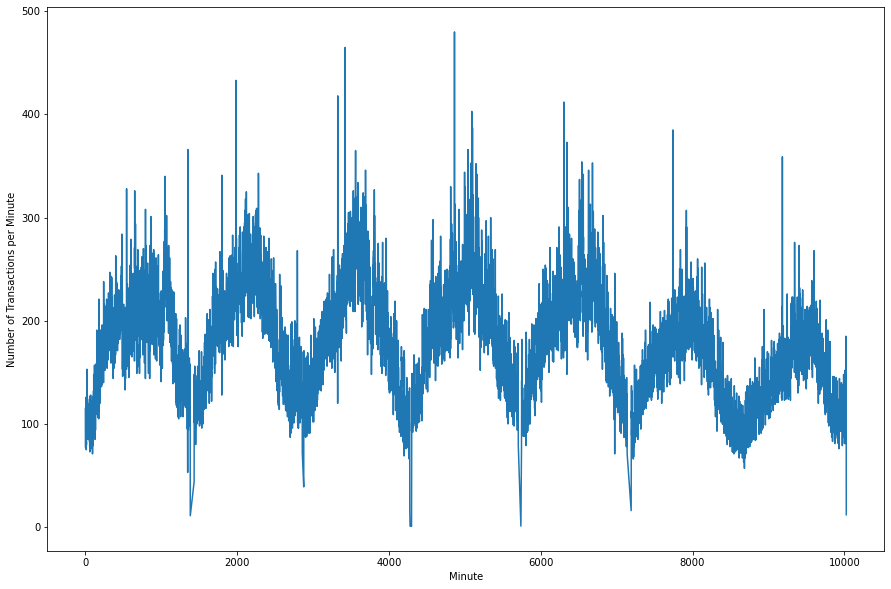

In [11]:
fig, ax = plt.subplots(figsize=(15,10))

plt.plot(df_test.groupby('epoch').count().hash)
plt.xlabel('Minute')
plt.ylabel('Number of Transactions per Minute')

plt.show()

### Get Historical Data per Address

In [12]:
%%time
df['output_addr_str'] = [','.join(addr) for addr in df['output_addr']]
df_clean = df[(df.input_value_tot > 0)
                 & (df.output_value_tot > 0)
                 & (len(df.output_addr) > 0)
                 & (len(df.input_addr) > 0)]
times = df_clean.groupby('output_addr_str')['time'].apply(list)
tx_volume_usd_rough = df_clean.groupby('output_addr_str').output_value_tot.sum() * 1e-8 * 22e3

CPU times: user 1min 2s, sys: 1.51 s, total: 1min 4s
Wall time: 1min 4s


In [16]:
%%time
def get_historical_times(r):
    max_time = r.dt_time
    min_time = r.dt_time - timedelta(days=7)
    return sorted([dt.fromtimestamp(t) for t in times[r.output_addr_str] if dt.fromtimestamp(t) < max_time 
                    and dt.fromtimestamp(t) > min_time])

df_test['arrival_times'] = df_test.apply(get_historical_times, axis=1)

CPU times: user 5min 24s, sys: 15.2 s, total: 5min 39s
Wall time: 6min


In [17]:
df_test.shape

(1746624, 17)

In [30]:
df_test = df_test.join(pd.DataFrame(tx_volume_usd_rough), on = 'output_addr_str', rsuffix='usd_historical')

In [31]:
%%time
load_data.save_timing_df(df_test)

CPU times: user 1min 50s, sys: 24.3 s, total: 2min 15s
Wall time: 2min 35s


In [17]:
%%time
df_test = load_data.load_timing_df()

CPU times: user 2min 54s, sys: 12.8 s, total: 3min 7s
Wall time: 3min 12s


### Old: Get Sample of Lifetime Historical Address-Level Data (to compute $g$)

In [19]:
df_batched_single = df_batched[df_batched.n_outputs == 1]
batched_addrs = df_batched_single['output_addr_str'].unique()

load_all_addr_data(batched_addrs, DS, 'batched')

df_addr_data = get_addresses(DS, 'batched')
df1 = df_batched.set_index('output_addr_str')
df2 = df_addr_data.set_index('addr')
df_batched_full = df1.join(df2, how='inner').reset_index().rename(columns={'index': 'addr'})

NameError: name 'df_batched' is not defined

In [12]:
df_addr_data = get_addresses(DS, 'batched')
df1 = df_batched.set_index('output_addr_str')
df2 = df_addr_data.set_index('addr')
df_batched_full = df1.join(df2, how='inner').reset_index().rename(columns={'index': 'addr'})

In [16]:
df_unbatched_single = df_unbatched[df_unbatched.n_outputs == 1].sample(n=4000, random_state=0)
unbatched_addrs = df_unbatched_single['output_addr_str'].unique()

load_all_addr_data(unbatched_addrs, DS, 'unbatched', sleep_time=3.0)

===== Fetching data for 3752 addresses =====
25 addresses already loaded
50 addresses already loaded
75 addresses already loaded
100 addresses already loaded
125 addresses already loaded
150 addresses already loaded
175 addresses already loaded
200 addresses already loaded
225 addresses already loaded
250 addresses already loaded
275 addresses already loaded
300 addresses already loaded
325 addresses already loaded
350 addresses already loaded
375 addresses already loaded
400 addresses already loaded
425 addresses already loaded
450 addresses already loaded
475 addresses already loaded
500 addresses already loaded
525 addresses already loaded
550 addresses already loaded
575 addresses already loaded
600 addresses already loaded
625 addresses already loaded
650 addresses already loaded
675 addresses already loaded
700 addresses already loaded
725 addresses already loaded
750 addresses already loaded
775 addresses already loaded
800 addresses already loaded
825 addresses already loaded
8

In [22]:
df_addr_data = get_addresses(DS, 'unbatched')
df1 = df_unbatched_single.set_index('output_addr_str')
df2 = df_addr_data.set_index('addr')
df_unbatched_full = df1.join(df2, how='inner').reset_index().rename(columns={'index': 'addr'})

In [26]:
df_batched_full.shape, df_unbatched_full.shape

((3048, 20), (3996, 20))

In [28]:
batch_sizes = df_batched_full.groupby(['epoch', 'addr'])['time'].count()
batch_sizes[batch_sizes == 2].count()

# total # of instances of batching
len(batch_sizes)

887

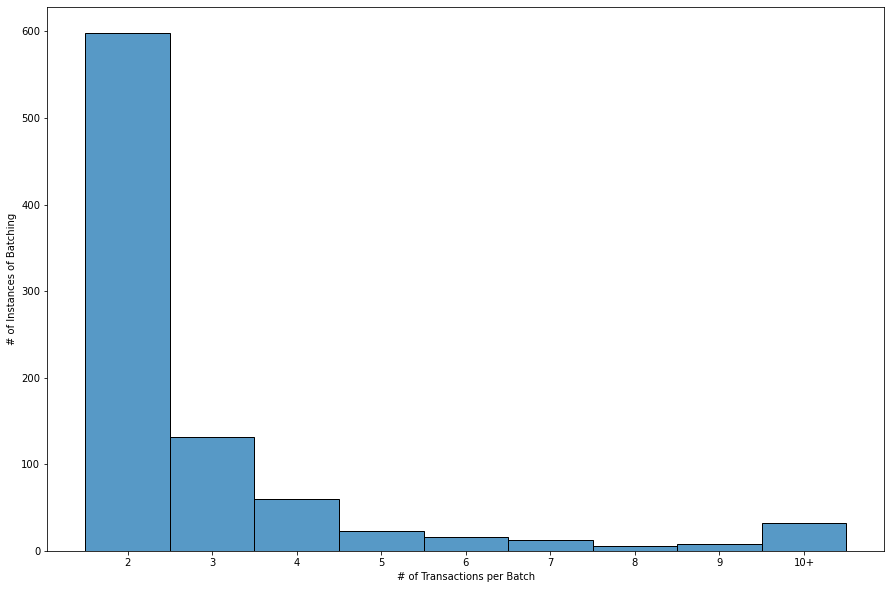

In [29]:
fig, axes = plt.subplots(figsize=(15,10))

cat = [min(b, 10) for b in batch_sizes]
sns.histplot(cat, bins = np.arange(2,12))

plt.xticks(np.arange(2,11)+0.5, labels=[str(n) for n in np.arange(2,10)] + ['10+'])

plt.ylabel('# of Instances of Batching')
plt.xlabel('# of Transactions per Batch')
plt.show()

In [37]:
def compute_g_percentile(times, p=75):
    diffs = np.diff(times)
    zeros = sum(diffs == timedelta(0))
    if zeros == len(diffs):
        return np.inf
    else:
        return np.percentile(diffs[diffs != timedelta(0)], p)

def bucket_time(t):
    if t == np.inf:
        return 6
    if t <= timedelta(minutes = 60):
        return 0
    if t <= timedelta(minutes = 60*12):
        return 1
    if t <= timedelta(minutes = 60*24):
        return 2
    if t <= timedelta(minutes = 60*48):
        return 3
    if t <= timedelta(minutes = 60 * 24 * 7):
        return 4
    return 5

time_labels = ['<1 hr', '1-12 hrs', '12-24 hrs', '1-2 days', '2 days - 1 week', 
                                      '>1 week', 'Infinite\n(No other tx)']

In [39]:
df_batched_full['gap_time'] = df_batched_full['incoming_tx_times'].apply(compute_g_percentile)
df_unbatched_full['gap_time'] = df_unbatched_full['incoming_tx_times'].apply(compute_g_percentile)

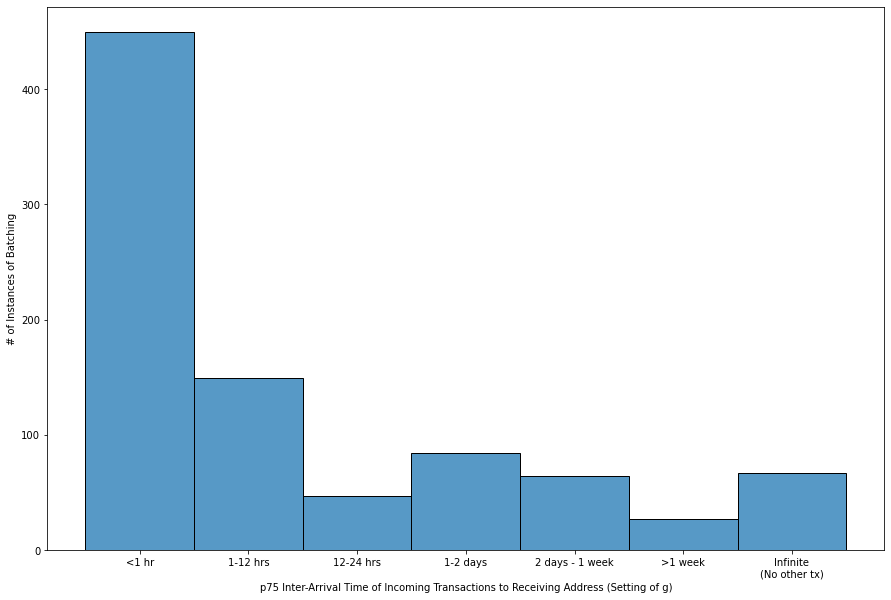

In [46]:
gap_times = df_batched_full.groupby(['addr', 'epoch'])['gap_time'].max()

fig, axes = plt.subplots(figsize=(15,10))
sns.histplot(gap_times.apply(bucket_time), bins = np.arange(0,8))
plt.xticks(np.arange(0,7)+0.5, labels=time_labels)
plt.ylabel('# of Instances of Batching')
plt.xlabel('p75 Inter-Arrival Time of Incoming Transactions to Receiving Address (Setting of g)')
plt.show()

In [61]:
sum(df_unbatched_full.lifetime_tx_count <= 2) / df_unbatched_full.shape[0]

0.37512512512512514

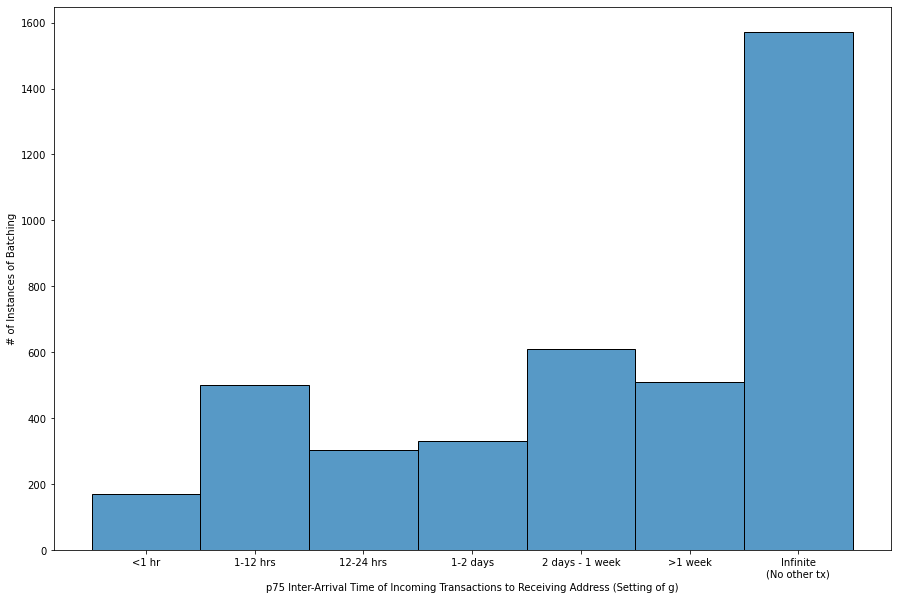

In [51]:
gap_times = df_unbatched_full.groupby(['addr', 'epoch'])['gap_time'].max()

fig, axes = plt.subplots(figsize=(15,10))
sns.histplot(gap_times.apply(bucket_time), bins = np.arange(0,8))
plt.xticks(np.arange(0,7)+0.5, labels=time_labels)
plt.ylabel('# of Instances of Batching')
plt.xlabel('p75 Inter-Arrival Time of Incoming Transactions to Receiving Address (Setting of g)')

plt.show()

### Aside: Fee Rate per Size of Transaction

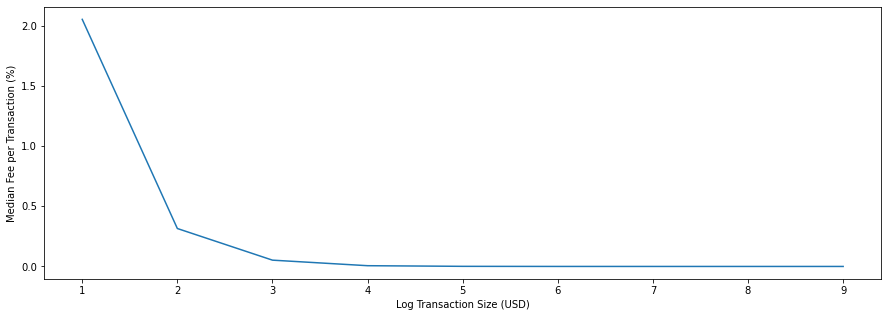

In [131]:
fig,axis = plt.subplots(figsize=(15,5))

df_fee= pd.DataFrame({'log_value': round(np.log10(df.input_value_tot_usd)), 
                      'fee_pct': 100. * df.fee / df.input_value_tot})

plt.plot(df_fee[df_fee.log_value > 0].groupby('log_value').fee_pct.median())
plt.xticks(sorted(df_fee[df_fee.log_value > 0].log_value.unique()))
plt.ylabel("Median Fee per Transaction (%)")
plt.xlabel("Log Transaction Size (USD)")
plt.show()